In [1]:

import os
import csv
import argparse
import numpy as np 
import scipy.misc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

file = 'data/fer2013/fer2013.csv'
output = 'data/fer2013/extracted'

w, h = 48, 48
image = np.zeros((h, w), dtype=np.uint8)
id = 1
from PIL import Image
from matplotlib.pyplot import imshow
# with open(file, 'r') as csvfile:
#     datareader = csv.reader(csvfile, delimiter =',')
# #     print headers 
#     for i,row in enumerate(datareader):  
#         if i==0:
#             continue
#         emotion = row[0]
#         pixels = list(map(int, row[1].split()))
# #         print(row)
#         usage = row[2]
#         #print emotion, type(pixels[0]), usage
#         pixels_array = np.asarray(pixels)

#         image = pixels_array.reshape(w, h)
#         #print image.shape

#         stacked_image = np.dstack((image,) * 3)
#         #print stacked_image.shape


#         image_folder = os.path.join(output, usage)
#         if not os.path.exists(image_folder):
#             os.makedirs(image_folder)
#         image_file =  os.path.join(image_folder , str(id) + '.jpg')
#         scipy.misc.imsave(image_file, stacked_image)
#         id += 1 
#         if id % 100 == 0:
#             print('Processed {} images'.format(id))

# print("Finished processing {} images".format(id))

In [2]:
import pandas as pd 
dataset = pd.read_csv(file)

In [ ]:
# for i, dirname in enumerate(dirnames):
#     filenames =[ os.path.join(dirname,filename) for filename in os.listdir(dirname)]
#     img=mpimg.imread(np.random.choice(filenames))
#     plt.subplot(len(dirnames) / columns + 1, columns, i + 1)
#     plt.imshow(img)
# plt.show()

### 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral


In [3]:
dataset.iloc[:10,:]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [4]:
dataset.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [5]:

training = dataset[dataset['Usage']=='Training']
validation = dataset[dataset['Usage']=='PublicTest']
test = dataset[dataset['Usage']=='PrivateTest']
training.shape
validation.shape
test.shape

(28709, 3)

(3589, 3)

(3589, 3)

In [6]:
train_val_common = set(training.pixels) & set(validation.pixels)
train_test_common = set(training.pixels) & set(test.pixels)
len(train_val_common)
len(train_test_common)

270

278

In [7]:
validation = validation[~validation['pixels'].isin(train_val_common)]
test = test[~test['pixels'].isin(train_test_common)]

In [8]:
def pixstr2numpy(pixstr):
    pixels = np.array(pixstr.split())
    pixels = pixels.reshape(w, h)
    return pixels.astype(np.int32)

def to3D(array):
    size = array.shape[0]
    X_t = np.zeros((size,48,48))
    for i,x in enumerate(array):
        X_t[i,:,:] = x
    X_t = X_t.astype(np.int32)
    return X_t

def X_Y_split(df):
    X_train,Y_train = df['pixels'].apply(pixstr2numpy),df['emotion'].astype(np.int32)
    X_train = np.array(X_train)
    X_train = to3D(X_train)
    Y_train  = Y_train.values
    return X_train,Y_train

In [9]:
X_train,Y_train = training['pixels'].apply(pixstr2numpy),training['emotion'].astype(np.int32)

In [32]:
X_train,Y_train = X_Y_split(training)

In [33]:
X_validation,Y_validation = X_Y_split(validation)
X_test,Y_test = X_Y_split(test)

In [34]:
X_train = np.array([X_train, X_train, X_train])
X_train =X_train.swapaxes(0, 1)
X_validation = np.array([X_validation, X_validation, X_validation])
X_validation = X_validation.swapaxes(0,1)
X_test = np.array([X_test, X_test, X_test])
X_test = X_test.swapaxes(0,1)
X_train.shape

(28709, 3, 48, 48)

In [ ]:
X_train.shape

In [35]:
import keras

Using TensorFlow backend.


In [45]:
MobileNet(input_shape=(3,48,48), alpha=1, shallow=False, classes=7, include_top=False)

TypeError: _obtain_input_shape() got an unexpected keyword argument 'include_top'

In [44]:
from keras.applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, \
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation
from keras.models import Model
from keras.engine.topology import get_source_inputs

'''Google MobileNet model for Keras.
# Reference:
- [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)
'''

def MobileNet(input_tensor=None, input_shape=None, alpha=1, shallow=False, classes=1000, include_top=True):
    """Instantiates the MobileNet.Network has two hyper-parameters
        which are the width of network (controlled by alpha)
        and input size.
        
        # Arguments
            input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
                to use as image input for the model.
            input_shape: optional shape tuple, only to be specified
                if `include_top` is False (otherwise the input shape
                has to be `(224, 224, 3)` (with `channels_last` data format)
                or `(3, 224, 244)` (with `channels_first` data format).
                It should have exactly 3 inputs channels,
                and width and height should be no smaller than 96.
                E.g. `(200, 200, 3)` would be one valid value.
            alpha: optional parameter of the network to change the 
                width of model.
            shallow: optional parameter for making network smaller.
            classes: optional number of classes to classify images
                into.
        # Returns
            A Keras model instance.
        """

    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=96,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Convolution2D(int(32 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(32 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(64 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(64 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(128 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(128 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(256 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(256 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if not shallow:
        for _ in range(5):
            x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            x = Convolution2D(int(512 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(512 * alpha), (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(1024 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = DepthwiseConvolution2D(int(1024 * alpha), (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Convolution2D(int(1024 * alpha), (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)
    out = Dense(classes, activation='softmax')(x)

    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, out, name='mobilenet')

    return model



'Google MobileNet model for Keras.\n# Reference:\n- [MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications](https://arxiv.org/pdf/1704.04861.pdf)\n'

In [40]:
from keras import backend as K, initializers, regularizers, constraints
from keras.backend import image_data_format
from keras.backend.tensorflow_backend import _preprocess_conv2d_input, _preprocess_padding
from keras.engine.topology import InputSpec
import tensorflow as tf
from keras.layers import Conv2D
from keras.legacy.interfaces import conv2d_args_preprocessor, generate_legacy_interface
from keras.utils import conv_utils

# This code mostly is taken form Keras: Separable Convolution Layer source code and changed according to needs.


def depthwise_conv2d_args_preprocessor(args, kwargs):
    converted = []
    if 'init' in kwargs:
        init = kwargs.pop('init')
        kwargs['depthwise_initializer'] = init
        converted.append(('init', 'depthwise_initializer'))
    args, kwargs, _converted = conv2d_args_preprocessor(args, kwargs)
    return args, kwargs, converted + _converted

legacy_depthwise_conv2d_support = generate_legacy_interface(
    allowed_positional_args=['filters', 'kernel_size'],
    conversions=[('nb_filter', 'filters'),
                 ('subsample', 'strides'),
                 ('border_mode', 'padding'),
                 ('dim_ordering', 'data_format'),
                 ('b_regularizer', 'bias_regularizer'),
                 ('b_constraint', 'bias_constraint'),
                 ('bias', 'use_bias')],
    value_conversions={'dim_ordering': {'tf': 'channels_last',
                                        'th': 'channels_first',
                                        'default': None}},
    preprocessor=depthwise_conv2d_args_preprocessor)


class DepthwiseConv2D(Conv2D):

    @legacy_depthwise_conv2d_support
    def __init__(self, filters,
                 kernel_size,
                 strides=(1, 1),
                 padding='valid',
                 data_format=None,
                 depth_multiplier=1,
                 activation=None,
                 use_bias=True,
                 depthwise_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 depthwise_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 depthwise_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super(DepthwiseConv2D, self).__init__(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            data_format=data_format,
            activation=activation,
            use_bias=use_bias,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            bias_constraint=bias_constraint,
            **kwargs)

        self.depth_multiplier = depth_multiplier
        self.depthwise_initializer = initializers.get(depthwise_initializer)
        self.depthwise_regularizer = regularizers.get(depthwise_regularizer)
        self.depthwise_constraint = constraints.get(depthwise_constraint)

    def build(self, input_shape):
        if len(input_shape) < 4:
            raise ValueError('Inputs to `SeparableConv2D` should have rank 4. '
                             'Received input shape:', str(input_shape))
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = 3
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs to '
                             '`SeparableConv2D` '
                             'should be defined. Found `None`.')
        input_dim = int(input_shape[channel_axis])
        depthwise_kernel_shape = (self.kernel_size[0],
                                  self.kernel_size[1],
                                  input_dim,
                                  self.depth_multiplier)

        self.depthwise_kernel = self.add_weight(
            shape=depthwise_kernel_shape,
            initializer=self.depthwise_initializer,
            name='depthwise_kernel',
            regularizer=self.depthwise_regularizer,
            constraint=self.depthwise_constraint)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=4, axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):

        if self.data_format is None:
            data_format = image_data_format()
        if self.data_format not in {'channels_first', 'channels_last'}:
            raise ValueError('Unknown data_format ' + str(data_format))

        x = _preprocess_conv2d_input(inputs, self.data_format)
        padding = _preprocess_padding(self.padding)
        strides = (1,) + self.strides + (1,)

        outputs = tf.nn.depthwise_conv2d(inputs, self.depthwise_kernel,
                                         strides=strides,
                                         padding=padding,
                                         rate=self.dilation_rate)

        if self.bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            rows = input_shape[2]
            cols = input_shape[3]
        elif self.data_format == 'channels_last':
            rows = input_shape[1]
            cols = input_shape[2]

        rows = conv_utils.conv_output_length(rows, self.kernel_size[0],
                                             self.padding,
                                             self.strides[0])
        cols = conv_utils.conv_output_length(cols, self.kernel_size[1],
                                             self.padding,
                                             self.strides[1])
        if self.data_format == 'channels_first':
            return (input_shape[0], self.filters, rows, cols)
        elif self.data_format == 'channels_last':
            return (input_shape[0], rows, cols, self.filters)

    def get_config(self):
        config = super(DepthwiseConv2D, self).get_config()
        config.pop('kernel_initializer')
        config.pop('kernel_regularizer')
        config.pop('kernel_constraint')
        config['depth_multiplier'] = self.depth_multiplier
        config['depthwise_initializer'] = initializers.serialize(self.depthwise_initializer)
        config['depthwise_regularizer'] = regularizers.serialize(self.depthwise_regularizer)
        config['depthwise_constraint'] = constraints.serialize(self.depthwise_constraint)
        return config

DepthwiseConvolution2D = DepthwiseConv2D

In [16]:

pixels = np.array(dataset.iloc[0,1].split())

In [17]:
pixels = pixels.astype(np.int32)
pixels = pixels.reshape(w, h)
im = Image.fromarray(pixels,mode='I') # np.asarray to convert back

In [18]:
def disp(pixels):
    pixels = np.array(pixels.split())
    pixels = pixels.astype(np.int32)
    pixels = pixels.reshape(w, h)
    im = Image.fromarray(pixels,mode='I') 
    imshow(im)

In [20]:
def dis(array):
    im = Image.fromarray(array,mode='I') 
    imshow(im)

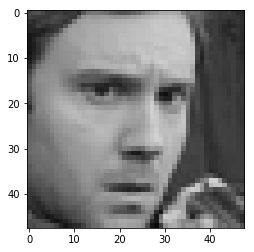

In [21]:
imshow(im)

In [23]:
from IPython.display import display,Image as jupI
display(jupI(pixels))

/usr/lib/python3/dist-packages/IPython/core/formatters.py:364: FormatterWarning: image/png formatter returned invalid type <class 'numpy.ndarray'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>